<h2>Single Hidden Layer Representation Learning(Numpy Implementation)</h2>
<h5>Problem Statement: For a classifcation problem:"Classifying MNIST images into two categories '>= 4' or '< 4'", evaluate performance of single hidden layer neural network with hindden units(5, 40, 200). Compare their performance with linear regression classifier.</h5>
<h3>1. Downloading and formating the Dataset</h3>
<br> 
1.1 Downloading the gz files for training and testing dataset

In [1]:
import urllib.request
#Training data
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train-images.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", "train-labels.gz")

#Testing data
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test-images.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", "test-labels.gz")

('test-labels.gz', <http.client.HTTPMessage at 0x7f0db0597e80>)

1.2 Reading and normalizing the input data and formating output into binary values.

In [2]:
import gzip
import numpy as np
def preprocess_data(data_file):
    with gzip.open(data_file,'r') as train_images:

# reading the meta information present in first 16 bytes
        train_images.read(4)
        num_of_examples = int.from_bytes(train_images.read(4), byteorder='big')
        num_of_rows = int.from_bytes(train_images.read(4), byteorder='big')
        num_of_cols = int.from_bytes(train_images.read(4), byteorder='big')

# reading images into numpy array
        data = np.frombuffer(
            train_images.read(num_of_examples * num_of_rows * num_of_cols),
            dtype=np.uint8)

# Normalizing each input image with zero mean and range -1 to 1.
    data = data.reshape(num_of_examples, num_of_rows * num_of_cols)
    data = (data - np.mean(data))/255

# adding the column of ones for bias parameter.
    data = np.append(data, np.ones((num_of_examples, 1)), axis=1)
    return data
data_train = preprocess_data('train-images.gz') 
data_test = preprocess_data('test-images.gz')

def preprocess_labels(labels_file):
    with gzip.open(labels_file,'r') as train_labels:
# reading the meta information present in first 8 bytes
        train_labels.read(4)
        num_of_examples = int.from_bytes(train_labels.read(4), byteorder='big')
# reading labels into numpy array
        labels = np.frombuffer(
            train_labels.read(num_of_examples),
            dtype=np.uint8)
# converting to binary values
    bin_output = np.zeros((labels.shape[0], 1))
    bin_output[np.where(labels > 4)] = 1
    return bin_output
output_train = preprocess_labels('train-labels.gz')
output_test = preprocess_labels('test-labels.gz')

In [3]:
def accuracy(prediction, target):
    prediction[np.where(prediction[:,0] < 0.5), 0] = 0
    prediction[np.where(prediction[:,0] >= 0.5), 0] = 1
    result = np.zeros(prediction.shape)
    result[np.where(prediction[:,0] == target[:,0])] = 1
    result = result.astype(np.int8)
    return int(np.sum(result))/ result.shape[0]

<h3>2. Baseline classifier using linear regression</h3>

In [4]:
def gradient_descent_linear(B, ITR, eta, train_d, train_l, test_d, test_l):
# Initializing the weights to zero
    W = np.zeros((train_l.shape[1], train_d.shape[1]))
    train_acc = []
    test_acc = []
    for i in range(ITR):
# Randomly choosing the datapoints from whole dataset with replacement.
        data_indexes = np.random.choice(np.arange(train_d.shape[0]), size=B, replace=True)
        x = train_d[data_indexes]
        y = train_l[data_indexes]
# Calculation of loss and accuracy each 100th part of iterations. 
        if (i + 1)%(ITR/100) == 0:
            train_acc.append(float(accuracy(np.matmul(train_d, W.T), train_l)))
            test_acc.append(float(accuracy(np.matmul(test_d, W.T), test_l)))
# Calculating gradient and updating the parameters with it. 
        G = - np.matmul((y-np.matmul(x, W.T)).T, x) / B
        W = W - eta*G
    return train_acc, test_acc

<h3>3. Shallow neural network with final layer as linear and sigmoid activation </h3>

In [5]:
def evaluate_shallow_nn(x, y, W0, W1, activation, calculate_gradient=False):
# Layer zero forward evaluation
    layer_0_activation = np.matmul(x, W0)
    layer_0_output = np.array(layer_0_activation)
    layer_0_output[np.where(layer_0_output <= 0)] = 0

# Layer one forward evaluation
    layer_1_activation = np.matmul(layer_0_output, W1)

    if activation == 'linear_nn':
        layer_1_output = np.array(layer_1_activation)

    elif activation == 'sigmoid_nn':
        layer_1_output = 1/(1 + np.exp(-layer_1_activation))

    if not calculate_gradient:
        return layer_1_output

# Backpropagation for gradient calculation

# Layer one backpropagation
    d_loss_d_layer_1_weights = -(y-layer_1_output) * layer_0_output 
    d_loss_d_layer_1_weights = np.mean(d_loss_d_layer_1_weights, axis=0, keepdims=True).T

# Layer zero backpropagation
    d_loss_d_layer_0_output = np.matmul(-np.mean(y-layer_1_output, axis=0, keepdims=True),
                                        W1.T).T
    d_layer_0_output_d_layer_0_activation = np.mean(layer_0_output, axis=0, keepdims=True).T
    d_layer_0_output_d_layer_0_activation[np.where(d_layer_0_output_d_layer_0_activation > 0 )] = 1
    d_loss_d_layer_0_activation = d_loss_d_layer_0_output * d_layer_0_output_d_layer_0_activation
    d_loss_d_layer_0_weights = np.matmul(d_loss_d_layer_0_activation, np.mean(x, axis=0, keepdims=True)).T

    return layer_1_output, d_loss_d_layer_1_weights, d_loss_d_layer_0_weights

def gradient_descent_shallow_nn(B, ITR, eta, train_d, train_l, test_d, test_l, k, activation):
# Initializing the weights to zero
    W0 = np.random.randn(train_d.shape[1], k)/train_d.shape[1]
    W1 = np.random.randn(k, (train_l.shape[1]))/k
    train_acc = []
    test_acc = []

    for i in range(ITR):
# Randomly choosing the datapoints from whole dataset with replacement.
        data_indexes = np.random.choice(np.arange(train_d.shape[0]), size=B, replace=True)
        x = train_d[data_indexes]
        y = train_l[data_indexes]
# Calculating gradient and updating the parameters with it. 
        
        (_,
         d_loss_d_layer_1_weights,
         d_loss_d_layer_0_weights) = evaluate_shallow_nn(x, y, W0, W1, activation, calculate_gradient=True)
        W1 = W1 - eta * d_loss_d_layer_1_weights
        W0 = W0 - eta * d_loss_d_layer_0_weights

        if (i + 1)%(ITR/100) == 0:
# Calculating the training and testing accuracy 
            predictions = evaluate_shallow_nn(train_d, train_l, W0, W1, activation)
            train_acc.append(float(accuracy(predictions, train_l)))
            predictions = evaluate_shallow_nn(test_d, test_l, W0, W1, activation)
            test_acc.append(float(accuracy(predictions, test_l)))
    return train_acc, test_acc

<h4>4. Training the neural nets with k = 5, 40, 200 and linear classifier with best found learning rate.</h4>


In [7]:
# Best configurations in format (Batch_Size, Iterations, Learning_Rate) 
best_configs = [(10, 50000, 0.01, 5, 'linear_nn'),
                (10, 50000, 0.01, 40, 'linear_nn'),
                (10, 50000, 0.01, 200, 'linear_nn'),
                (10, 50000, 0.001, 5, 'sigmoid_nn'),
                (10, 50000, 0.001, 40, 'sigmoid_nn'),
                (10, 50000, 0.001, 200, 'sigmoid_nn'),
                (10, 50000, 0.0001, None, 'linear_regression')
                ]

# Execution of SGD with selected configurations of different batch sizes. 
import time
acc_values = []
for B, ITR, eta, k, model in best_configs:
    t1 = time.time()
    if model != 'linear_regression':
        train_acc, test_acc = gradient_descent_shallow_nn(
            B, ITR, eta, data_train, output_train,
            data_test, output_test, k, model)
        acc_values.append((train_acc, test_acc))
    else:
        train_acc, test_acc = gradient_descent_linear(
            B, ITR, eta, data_train, output_train,
            data_test, output_test)
        acc_values.append((train_acc, test_acc))

    print('Model:', model)
    print('k = ', k)
    print('Learning Rate:', eta)
    print("Final Train Accuracy: ", acc_values[-1][0][-1])
    print("Final Test Accuracy: ", acc_values[-1][1][-1])
    print("Time: ", time.time()-t1)
    print()
  

Model: linear_nn
k =  5
Learning Rate: 0.01
Final Train Accuracy:  0.8473333333333334
Final Test Accuracy:  0.8536
Time:  22.227849006652832

Model: linear_nn
k =  40
Learning Rate: 0.01
Final Train Accuracy:  0.8508833333333333
Final Test Accuracy:  0.8549
Time:  68.62518763542175

Model: linear_nn
k =  200
Learning Rate: 0.01
Final Train Accuracy:  0.8839666666666667
Final Test Accuracy:  0.8835
Time:  140.7349247932434

Model: sigmoid_nn
k =  5
Learning Rate: 0.001
Final Train Accuracy:  0.8459166666666667
Final Test Accuracy:  0.852
Time:  23.970231294631958

Model: sigmoid_nn
k =  40
Learning Rate: 0.001
Final Train Accuracy:  0.8336166666666667
Final Test Accuracy:  0.836
Time:  63.1527259349823

Model: sigmoid_nn
k =  200
Learning Rate: 0.001
Final Train Accuracy:  0.8449833333333333
Final Test Accuracy:  0.8522
Time:  140.40022492408752

Model: linear_regression
k =  None
Learning Rate: 0.0001
Final Train Accuracy:  0.8539833333333333
Final Test Accuracy:  0.8595
Time:  9.13891

<h3>5. Comparing the optimization of neural networks with linear regressions using accuracy</h3>

<h4>k = 5</h4>

<Figure size 648x324 with 0 Axes>

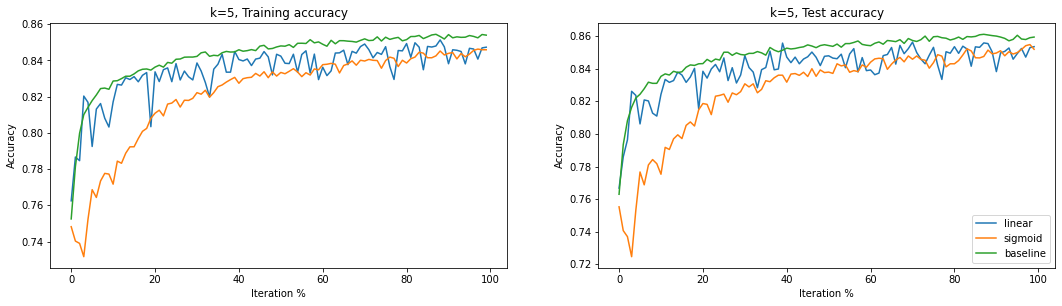

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4.5))
fig, axs = plt.subplots(1, 2, figsize=(18,4.5))
axs[0].plot(range(100), acc_values[0][0], label = 'linear')
axs[0].plot(range(100), acc_values[3][0], label = 'sigmoid')
axs[0].plot(range(100), acc_values[6][0], label = 'baseline')
axs[0].set_title('k=5, Training accuracy')
axs[0].set_xlabel('Iteration %')
axs[0].set_ylabel('Accuracy')
axs[1].plot(range(100), acc_values[0][1], label = 'linear')
axs[1].plot(range(100), acc_values[3][1], label = 'sigmoid')
axs[1].plot(range(100), acc_values[6][1], label = 'baseline')
axs[1].set_title('k=5, Test accuracy')
axs[1].set_xlabel('Iteration %')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

<h4>k = 40</h4>

<Figure size 648x324 with 0 Axes>

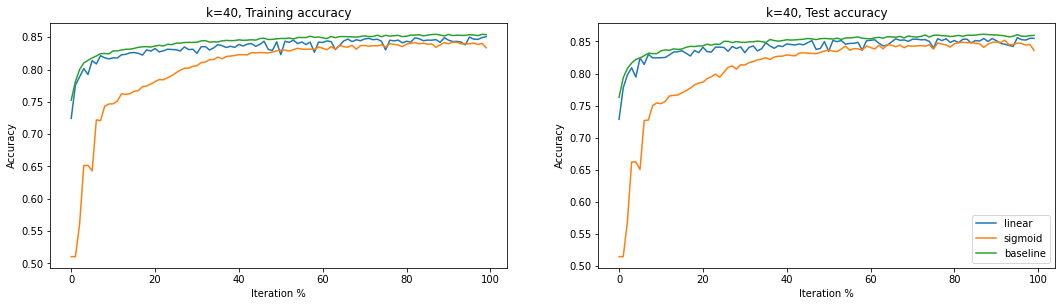

In [9]:
plt.figure(figsize=(9,4.5))
fig, axs = plt.subplots(1, 2, figsize=(18,4.5))
axs[0].plot(range(100), acc_values[1][0], label = 'linear')
axs[0].plot(range(100), acc_values[4][0], label = 'sigmoid')
axs[0].plot(range(100), acc_values[6][0], label = 'baseline')
axs[0].set_title('k=40, Training accuracy')
axs[0].set_xlabel('Iteration %')
axs[0].set_ylabel('Accuracy')
axs[1].plot(range(100), acc_values[1][1], label = 'linear')
axs[1].plot(range(100), acc_values[4][1], label = 'sigmoid')
axs[1].plot(range(100), acc_values[6][1], label = 'baseline')
axs[1].set_title('k=40, Test accuracy')
axs[1].set_xlabel('Iteration %')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

<h4>k = 200</h4>

<Figure size 648x324 with 0 Axes>

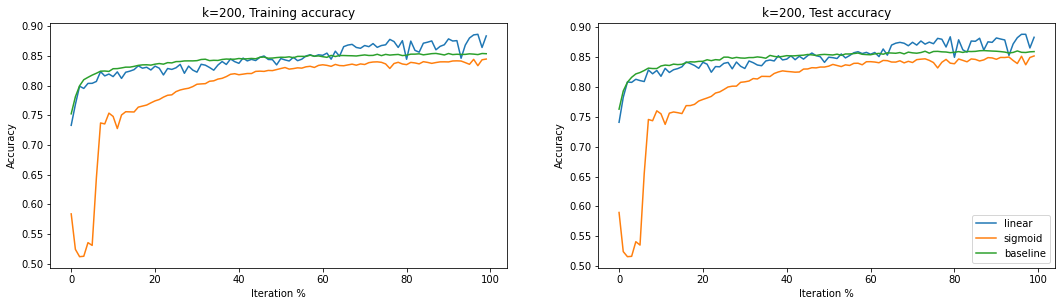

In [10]:
plt.figure(figsize=(9,4.5))
fig, axs = plt.subplots(1, 2, figsize=(18,4.5))
axs[0].plot(range(100), acc_values[2][0], label = 'linear')
axs[0].plot(range(100), acc_values[5][0], label = 'sigmoid')
axs[0].plot(range(100), acc_values[6][0], label = 'baseline')
axs[0].set_title('k=200, Training accuracy')
axs[0].set_xlabel('Iteration %')
axs[0].set_ylabel('Accuracy')
axs[1].plot(range(100), acc_values[2][1], label = 'linear')
axs[1].plot(range(100), acc_values[5][1], label = 'sigmoid')
axs[1].plot(range(100), acc_values[6][1], label = 'baseline')
axs[1].set_title('k=200, Test accuracy')
axs[1].set_xlabel('Iteration %')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.show()